# 实验一


In [176]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from array import array
import time
import scipy.stats as st
import seaborn as sns
import pandas as pd
import math
import pickle

In [177]:
import warnings
warnings.filterwarnings('ignore')
import rpy2
import rpy2.ipython
from rpy2 import robjects

In [5]:
%load_ext rpy2.ipython

In [48]:
%%R
require(mvtnorm)
require(coda)
require(ggplot2)
require(ggpubr)
require(rootSolve)
require(plyr)
require(pracma)

Exception ignored from cffi callback <function _consolewrite_ex at 0x00000265775C30D0>:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\pytorch-cuda\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "D:\Anaconda3\envs\pytorch-cuda\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd4 in position 0: invalid continuation byte
Exception ignored from cffi callback <function _consolewrite_ex at 0x00000265775C30D0>:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\pytorch-cuda\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "D:\Anaconda3\envs\pytorch-cuda\lib\site-packages\rpy2\rinterface_lib\conversion.py", 

# MH算法

In [320]:
#MH算法
def MH(z,T,theta_ini):
    N=z.shape[0]
    d=len(theta_ini)
    theta=np.zeros((d,T+1))
    theta[:,0]=theta_ini
    time_start = time.time()
    c= np.arange(N)
    for i in range(T):
        tp=np.random.normal(theta[:,i],0.05, d) #RW proposal to be tuned 均值为theta，方差为1.5
        u=np.random.rand() #0到1的随机数
        #theta[:,i]为当前的theta，tp为下一步是否要接受的theta
        #对数似然比求和按列
        start_logp=logpior(theta[:,i])+np.sum(loglik(c,z,theta[:,i]),axis=0)
        new_logp=logpior(tp)+np.sum(loglik(c,z,tp),axis=0)
        energy_change=new_logp-start_logp
        
        if np.log(u)<energy_change:
            theta[:,i+1]=tp
        else:
            theta[:,i+1]=theta[:,i]
        
    time_end = time.time()
    time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
    print(time_sum)
    return theta

# APMHT

In [545]:
#APMHT算法
def APMHT(z,T,ep, m,theta_ini):
    N=z.shape[0]
    d=len(theta_ini)
    theta=np.zeros((d,T+1))
    theta[:,0]=theta_ini
    number_llik_eval=0
    time_start = time.time()
    for i in range(T):
        tp=np.random.normal(theta[:,i],0.05, d) #RW proposal to be tuned 均值为theta，方差为1.5
        u=np.random.rand() #0到1的随机数
        l=0
        lbar=0
        lsqbar=0
        n=0
        done=False
        #计算mu0
        mu0=(1/N)*(np.log(u)+logpior(theta[:,i])-logpior(tp))
        #设置batch大小
        batch=0
        #样本的index
        index=np.arange(N)
        while not done:
            draw=np.random.randint(0,len(index),min(m,N-n))
            batch=np.hstack((draw,batch))
            n=n+min(m,N-n)
            #不放回抽样，去掉draw的列
            index=np.delete(index, draw)
            l=loglik(batch,z,tp)-loglik(batch,z,theta[:,i])
            #对数似然比求均值按列
            lbar=np.mean(l,axis=0)
            lsqbar=np.mean(l**2,axis=0)
            
            sd_batch=(n/(n-1))**(1/2)*(lsqbar-lbar**2)
            sd_hat=(sd_batch/(n**(1/2)))*((1-(n-1)/(N-1))**(1/2))
            
            
            #双边t检验 ×2
            delta=st.t.sf(abs((lbar-mu0)/sd_hat),n-1)*2

            
            if delta<ep:
                if lbar>mu0:
                    theta[:,i+1]=tp
                else:
                    theta[:,i+1]=theta[:,i]
                done=True
                number_llik_eval=number_llik_eval+n
        
    time_end = time.time()
    time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
    print(time_sum)
    print(number_llik_eval)
    return theta, number_llik_eval

# Confidence Sampler

In [563]:
## Concentration bounds
# N:Number of points

def ctBernsteinSerfling(N,n,a,b,sigma,delta):
    """
    Bernstein-type bound without replacement, from (Bardenet and Maillard, to appear in Bernoulli)
    """
    l5 = np.log(5/delta)
    kappa = 7.0/3+3/np.sqrt(2)
    if n<=N/2:
        rho = 1-1.0*(n-1)/N
    else:
        rho = (1-1.0*n/N)*(1+1.0/n)
    return sigma*np.sqrt(2*rho*l5/n) + kappa*(b-a)*l5/n

def ctHoeffdingSerfling(N,n,a,b,delta):
    """
    Classical Hoeffding-type bound without replacement, from (Serfling, Annals of Stats 1974)
    """
    l2 = np.log(2/delta)
    if n<=N/2:
        rho = 1-1.0*(n-1)/N
    else:
        rho = (1-1.0*n/N)*(1+1.0/n)
    return (b-a)*np.sqrt(rho*l2/2/n)

def ctBernstein(N,n,a,b,sigma,delta):
    """
    Classical Bernstein bound, see e.g. the book by Boucheron, Lugosi, and Massart, 2014.
    """
    l3 = np.log(3/delta)
    return sigma*np.sqrt(2*l3/n) + 3*(b-a)*l3/n
#Confidence Sampler算法
def Conf(z,T,m,theta_ini):
    N=z.shape[0]
    d=len(theta_ini)
    theta=np.zeros((d,T+1))
    theta[:,0]=theta_ini
    number_llik_eval=0
    delta = .1
    gamma = 2.
    time_start = time.time()
    for i in range(T):
        np.random.shuffle(z)
        tp=np.random.normal(theta[:,i],0.05, d) #RW proposal to be tuned 均值为theta，方差为1.5
        u=np.random.rand() #0到1的随机数
        l=0
        al= np.arange(N)
        lall=loglik(al,z,tp)-loglik(al,z,theta[:,i])
        a=np.min(lall)
        b=np.max(lall)
        n=m
        done=False
        #计算mu0
        psi=(1/N)*(np.log(u)+logpior(theta[:,i])-logpior(tp))
        #设置batch大小
        batch=0
        #样本的index
        index=np.arange(N)
        cpt=0
        while not done and n<N:
            n = min(N,np.floor(gamma*n))
            batch=np.arange(int(n))
            cpt+=1
            deltaP = delta/2/cpt**2
            #print(batch)
            l=loglik(batch,z,tp)-loglik(batch,z,theta[:,i])
            #对数似然比求均值按列
            
            Lambda=np.mean(l)
            sigma = np.std(l)
            
            c=ctBernstein(N,n,a,b,sigma,deltaP)
            
            if np.abs(Lambda-psi) > c:
                done = True

        
        if Lambda>psi:
            theta[:,i+1]=tp
        else:
            theta[:,i+1]=theta[:,i]
                
        number_llik_eval=number_llik_eval+n
        
    time_end = time.time()
    time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
    print(time_sum)
    print(number_llik_eval)
    return theta, number_llik_eval

# MiniBatch

In [9]:
# def logist(x):
#     return 1/(1+np.exp(-x))
# def C_sigma(N,s_x,lbd):
#     #N为分割份数，V为区间边界，s_x为正态分布方差，lbd为lambda正则化项系数，论文中取10.
#     #第一个为起点，第二个为终点，第三个为步长。
#     V=10
#     i=np.arange(-2*N,2*N+1)
#     #i=np.arange(-N,N+1)
#     j=np.arange(-N,N+1)
#     X=i*V/N
#     Y=j*V/N
#     m=len(X)
#     n=len(Y)
#     X_1=X.reshape(m,1)
#     X_1=np.column_stack((X,np.ones((m,1))))
#     Y_1=Y.reshape(1,n)
#     Y_1=np.row_stack((np.ones((1,n)),-Y))
#     M=X_1.dot(Y_1)
    
#     M=st.norm.cdf(M,0,s_x)
#     v=logist(X)
#     #v=st.norm.cdf(X,0,s_x)
#     u=M.T.dot(M)+lbd*np.eye((n))
#     u=np.linalg.inv(u).dot(M.T).dot(v)
#     return u

In [10]:
# N=4000
# V=10
# i=np.arange(-2*N,2*N+1)
# #i=np.arange(-N,N+1)
# j=np.arange(-N,N+1)
# X=i*V/N
# Y=j*V/N 
# u=C_sigma(N,1,10)
# #u为密度函数

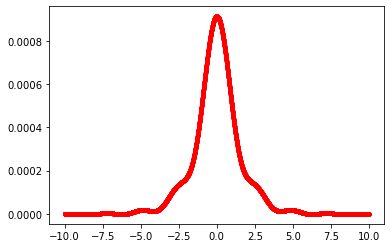

In [11]:
# u=np.maximum(u,0)
# plt.plot(Y,u,label='sin(x)',color='red', linewidth=3,marker='o',markersize=3)

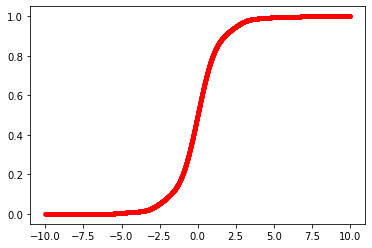

In [12]:
# #计算累计分布cdf，并绘制图像
# def cdf_val(p,X):
#     p_norm = p/np.trapz(p,X)
#     return np.array([np.trapz(p_norm[:n],X[:n]) for n in range(len(p_norm))])  
# cdf=cdf_val(u,Y)
# plt.plot(Y,cdf,label='sin(x)',color='red', linewidth=3,marker='o',markersize=3)

In [13]:
# #xvals为累计分布函数的定义域，r为0到1的随机数
# def fun_inv(xvals,cdf_vals,r):
#     """
#     函数是给定 0<u<1,然后根据xvals 和cdf_vals 定义的CDF函数，求出对应的x，使得CDF(x)约等于u
#     函数的思路是对于给定的u，找到cdf_vals中比u大的数，由于cdf_vals是和xvals是一一对应的，
#     所以可以找到大于 u 的cdf_vals中的最小值，对应的xvals就是对F^{-1}(u)的估计。 

#     这里要求xvals和cdf_vals都是升序排列的。
#     """
#     if isinstance(r,np.ndarray):
#         assert(np.all(np.logical_and(0<r,r<1)))
#         num_u = r.shape[0]
#         xouts = np.zeros((num_u))
#         for ii in range(num_u):
#             inds = (cdf_vals>r[ii]).nonzero()
#             if len(inds[0])>0:
#                 xouts[ii] = xvals[inds[0][0]]
#             else:
#                 xouts[ii]=xvals[-1]
#         return xouts
#     else:
#         assert(0<r<1)
#         ind = (cdf_vals>r).nonzero()
#         xout = xvals[ind[0][0]]
#         return xout

In [14]:
# r=np.random.rand(4000)
# #y为在cdf中抽样的样本，样本量与r一致
# Xc_4000=fun_inv(Y,cdf,r)


In [15]:
# file = open('E:\研究生\毕业论文\code\Xc_4000.pickle', 'wb') #以.pickle格式保存；二进制写入
# pickle.dump(Xc_4000, file) #将a_dict内容写入file
# file.close()

# 只读Xc_4000

In [18]:
file = open('E:\研究生\毕业论文\code\Xc_4000.pickle', 'rb') #二进制读取
Xc_4000 = pickle.load(file) #读取结果存入a_dict1
file.close()

In [616]:
#MiniMH算法
def MiniMH(z,T,m,theta_ini):
    N=z.shape[0]
    d=len(theta_ini)
    theta=np.zeros((d,T+1))
    theta[:,0]=theta_ini
    number_llik_eval=0
    full_N=0
    num_Xc=0
    time_start = time.time()
    for i in range(T):
        tp=np.random.normal(theta[:,i],0.05, d) #RW proposal to be tuned 均值为theta，方差为1.5
        u=np.random.rand() #0到1的随机数
        n=0
        done=False
        #设置batch大小
        batch=-1
        #样本的index
        index=np.arange(N)
        psi=logpior(theta[:,i])-logpior(tp)
        while not done:
            draw=np.random.randint(0,len(index),min(m,N-n))
            if type(batch)==int:
                batch=draw
            else:
                batch=np.hstack((draw,batch))
            n=n+min(m,N-n)
            #不放回抽样，去掉draw的列
            index=np.delete(index, draw)
            l=(N/10)*(loglik(batch,z,tp)-loglik(batch,z,theta[:,i]))
            
            
            #对数似然比求均值按列
#             sumOfSquares=np.sum(l**2,axis=0)
#             sumOfValues=np.sum(l,axis=0)
            
            deltaStar=np.mean(l,axis=0)-psi
#             sampleVariance = (sumOfSquares/n - (sumOfValues/n)**2)/ n
            sampleVariance=(1/n)*np.var(l,axis=0)
            
#             print("sampleVariance",sampleVariance)
#             print("sampleVariance2",sampleVariance2)
            #print(sampleVariance)
            
            numStd = deltaStar / np.sqrt(sampleVariance)
#             print(deltaStar)
#             print(numStd)
            accept=False
            if n==N:
                full_N+=1
                #print("WARNING: test used entire dataset but variance is still too high.")
                if deltaStar > 0:
                    accept=True
            #Abnormally good or bad minibatches.
            elif abs(numStd)>5:
                if numStd>0:
                    accept=True
                else:
                    continue
            elif sampleVariance >= 1:
                #print("WARNING: test used entire dataset but variance is still too high.")
                continue
            else:
                Xn=np.random.normal(0, 1-sampleVariance, 1)
                Xc=np.random.choice(Xc_4000)
                testStat=deltaStar+Xn+Xc
                num_Xc+=1
                if testStat > 0:
                    accept=True
            
            if accept:
                theta[:,i+1]=tp
            else:
                theta[:,i+1]=theta[:,i]
            done=True
            number_llik_eval=number_llik_eval+n
        
    time_end = time.time()
    time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
    print(time_sum)
    print("full_N_time:", full_N)
    print("num_Xc:", num_Xc)
    return theta, number_llik_eval

# 数据

In [530]:
#先验分布为一维正态分布
def pior(theta,p_mu=1,p_sigma=1):
    #先验分布 均值为1 方差为1的正态分布
    return st.norm.pdf(theta,p_mu,p_sigma)
def logpior(theta,p_mu=1,p_sigma=1):
    #先验分布 均值为1 方差为1的正态分布取对数
    return np.log(st.norm.pdf(theta,p_mu,p_sigma))
    
def lik(i,z,theta):
    #似然函数为均值为theta，方差为1的正态分布
    #对z的第i行计算正态分布的密度函数，相当于计算每一个样本点d维的似然
    return st.norm.pdf(z[i],theta,1)

def loglik(i,z,theta):
    #对z的第i行计算正态分布的密度函数取对数
    return np.log(st.norm.pdf(z[i],theta,1))

In [531]:
#参数
n=10000
#初值为1
l_mu=[1]
T=20000
ep=0.05
m=100

In [73]:
#数据
z=np.random.normal(1, 1, n)
x=z.reshape((n,1))

In [352]:
tn11=MH(z,T,l_mu)

21.992964506149292


In [343]:
# realmh=tn11[0][10001:]
# realmh.reshape(1,10000)

array([[0.9966143 , 0.9966143 , 0.9966143 , ..., 0.99619284, 0.99619284,
        0.99619284]])

In [350]:
realmh=np.hstack((realmh,tn11[0][10001:]))

In [647]:
tnb=tn11[0][:]
tnb
zmean=z.mean()
zmean=(n/(n+1))*zmean+1/(n+1)
zstd=1/(n+1)

In [648]:
%%R -i tn11,zmean,zstd

statip::hellinger(rnorm(2e4,zmean,zstd*100),tn11)


[1] 0.03269004


In [649]:
%%R -i tnb
a<-as.mcmc(tnb)
a<-as.numeric(a)
effectiveSize(a)
geweke.diag(a,frac1=0.1, frac2=0.5)


Fraction in 1st window = 0.1
Fraction in 2nd window = 0.5 

   var1 
-0.7078 



In [650]:
robjects.r('a<-as.mcmc(tnb)')
robjects.r('coda::effectiveSize(a<-as.numeric(a))')

3286.491708


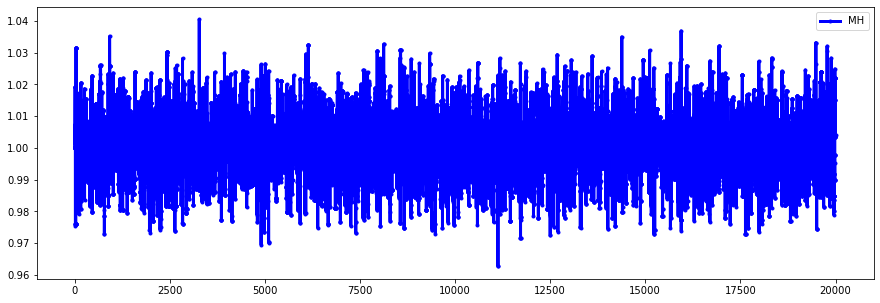

In [651]:
#theta的游程图
xp=np.arange(T+1)
plt.figure(figsize=(15, 5))
plt.plot(xp,tn11.transpose(),label='MH',color='blue', linewidth=3,marker='o',markersize=3)
plt.legend()

In [ ]:
tn2,nle=APMHT(z,T,ep, m,l_mu)

In [ ]:
#theta的游程图
xp=np.arange(7001)
a=tn[0][3000:]
plt.figure(figsize=(15, 5))
plt.plot(xp,a.transpose(),color='red', linewidth=3,marker='*',markersize=1)

# 其他MCMC


In [559]:
ep=0.05
m=100
theta_ini=l_mu
nle=0
nle5=0

In [560]:
for i in range(5):
    tnA,nle=APMHT(z,T,ep, m,theta_ini)
    nle5+=nle
    

16.027827501296997
2115300
15.865055799484253
2124000
16.029584407806396
2120800
15.889516830444336
2113600
15.937410354614258
2118100


In [581]:
nle5/5


10591800

In [562]:
2118360/T

105.918

In [635]:
tnAr=tnA[0][:]

In [636]:
%%R -i tnAr,realmh

statip::hellinger(realmh,tnAr)

[1] 0.6420446


In [637]:
%%R -i tnAr
a<-as.mcmc(tnAr)
a<-as.numeric(a)
effectiveSize(a)
geweke.diag(a,frac1=0.3, frac2=0.7)


Fraction in 1st window = 0.3
Fraction in 2nd window = 0.7 

   var1 
-0.7188 



In [638]:
robjects.r('a<-as.mcmc(tnAr)')
robjects.r('coda::effectiveSize(a<-as.numeric(a))')

1471.447166


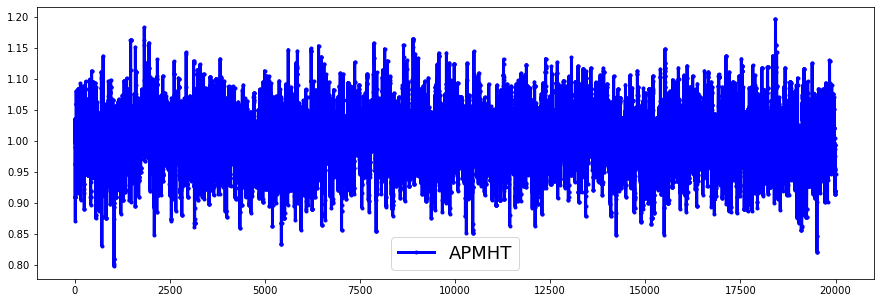

In [558]:
#theta的游程图
xp=np.arange(T+1)
plt.figure(figsize=(15, 5))
plt.plot(xp,tnA.transpose(),label='AustMH',color='blue', linewidth=3,marker='o',markersize=3)
plt.legend(fontsize=18)

In [564]:
nle5C=0

In [565]:
for i in range(5):
    tnC,nle=Conf(z,T,m,theta_ini)
    nle5C+=nle

112.74440312385559
197014000.0
111.20735454559326
197113200.0
112.29259991645813
197021000.0
113.88982558250427
196974400.0
113.8105206489563
196907200.0


In [566]:
nle5C/5

197005960.0

In [567]:
197005960/T

9850.298

In [639]:
tnCr=tnC[0][:]

In [640]:
%%R -i tnCr,realmh

statip::hellinger(realmh,tnCr)

[1] 0.004871503


In [641]:
%%R -i tnCr
a<-as.mcmc(tnCr)
a<-as.numeric(a)
effectiveSize(a)
geweke.diag(a,frac1=0.3, frac2=0.7)


Fraction in 1st window = 0.3
Fraction in 2nd window = 0.7 

 var1 
0.744 



In [642]:
robjects.r('a<-as.mcmc(tnCr)')
robjects.r('coda::effectiveSize(a<-as.numeric(a))')

2869.446660


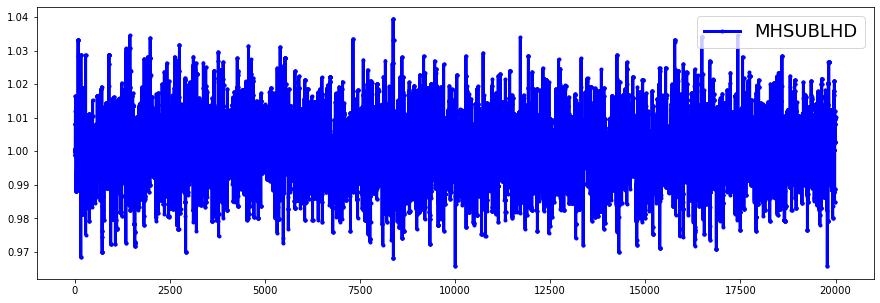

In [568]:
#theta的游程图
xp=np.arange(T+1)
plt.figure(figsize=(15, 5))
plt.plot(xp,tnC.transpose(),label='MHSUBLHD',color='blue', linewidth=3,marker='o',markersize=3)
plt.legend(fontsize=18)

In [620]:
nle5M=0
m=100
#tnM,nle=MiniMH(z,T,m,theta_ini)

In [621]:
for i in range(5):
    tnM,nle=MiniMH(z,T,m,theta_ini)
    nle5M+=nle

276.13013219833374
full_N_time: 1793
num_Xc: 18194
270.4213795661926
full_N_time: 1880
num_Xc: 18112
271.07038736343384
full_N_time: 1782
num_Xc: 18206
264.7956097126007
full_N_time: 1734
num_Xc: 18248
265.8758339881897
full_N_time: 1727
num_Xc: 18261


In [622]:
nle5M/5

49803700.0

In [623]:
49803700/T

2490.185

In [633]:
tnMr=tnM[0][10000:]

In [634]:
%%R -i tnMr,realmh

statip::hellinger(realmh,tnMr)

[1] 0.4945585


In [631]:
%%R -i tnMr
a<-as.mcmc(tnMr)
a<-as.numeric(a)
effectiveSize(a)
geweke.diag(a,frac1=0.3, frac2=0.7)


Fraction in 1st window = 0.3
Fraction in 2nd window = 0.7 

   var1 
-0.0218 



In [632]:
robjects.r('a<-as.mcmc(tnMr)')
robjects.r('coda::effectiveSize(a<-as.numeric(a))')

2804.706081


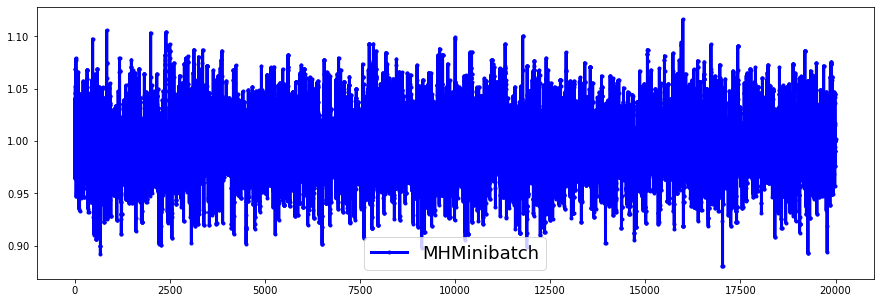

In [628]:
xp=np.arange(T+1)
plt.figure(figsize=(15, 5))
plt.plot(xp,tnM.transpose(),label='MHMinibatch',color='blue', linewidth=3,marker='o',markersize=3)
plt.legend(fontsize=18)

# PMMin

In [1]:
def dist_eucl(x1,x2):
    #算出1行d列个距离
    return np.linalg.norm(x1-x2,axis=1)

def clustering(x,eps):
    n=x.shape[0]
    I=np.zeros(n)#Indicator variable, 1 if obs i has been given a cluster
    z=np.zeros(x.shape[1]) #centroids
    C=np.zeros(1) #indices inside each clusters
    k=0
    index=np.arange(n)
    for j in range(n):
        if I[j]==0:
            p=np.where(dist_eucl(x[np.array(1-I, dtype = bool),:],x[j,:])<=eps)
            C_current=index[p]
            
            index=np.delete(index,p)
        
            if len(C_current)==1:
                z=np.vstack((x[C_current,:][0],z))
            else:
                z=np.vstack(((1/len(C_current))*np.sum(x[C_current,:],axis=0),z))
            I[C_current]=1
            C=pd.concat([pd.DataFrame(C_current),pd.DataFrame(C)],axis=1)
            k=k+1
    return k,z.transpose(),C

In [472]:
outk,outz,C=clustering(x,0.05)
outk

106

In [476]:
data=x

def generateB(data,outk,outz):
    B=[]
    d=outz.shape[0]
    for k in range(outk):
        B.append(np.zeros((d,d)))
        for i in C.iloc[:,k]:
            if not math.isnan(i):
                b=data[int(i),:]-outz[:,k]
                m=b.shape[0]
                B[-1]=B[-1]+np.dot(b.reshape(m,1),b.reshape(1,m))
    return B
B=generateB(data,outk,outz)

In [686]:
def PMMIN(data,z,K,C,m, Time, theta_ini):
    #z是质心
    #N个样本点
    N=data.shape[0]
    d=len(theta_ini)
    d_b=np.zeros(m)
    d_bp=np.zeros(m)
    theta=np.zeros((d,Time+1))
    theta[:,0]=theta_ini
    Xc_num=0
    time_start = time.time()
    
    for t in range(Time):
        accept=False
        bp=np.random.normal(theta[:,t],0.05, d) #RW proposal to be tuned
        u=np.random.choice(np.arange(N),m,replace=True)#放回抽样？抽m个样本
        for i in range(m):
            #找出这个样本属于的类别
            coord=np.where(C.values==u[i])[1][0]
            #print(coord)
            d_b[i]=loglik(data[u[i],:],theta[:,t])-loglik(z[:,coord],theta[:,t])-np.dot(gradient_llik(z[:,coord],theta[:,t]),(data[u[i],:]-z[:,coord]))-0.5*(data[u[i],:]-z[:,coord]).dot(hessian_llik(z[:,coord],theta[:,t])).dot(data[u[i],]-z[:,coord])
            d_bp[i]=loglik(data[u[i],:],bp)-loglik(z[:,coord],bp)-np.dot(gradient_llik(z[:,coord],bp),(data[u[i],:]-z[:,coord]))-0.5*(data[u[i],:]-z[:,coord]).dot(hessian_llik(z[:,coord],bp)).dot(data[u[i],]-z[:,coord])
            #print(d_b[i])
        print(d_b)
        mu_b=np.mean(d_b)
        sigma_b=np.var(d_b)
        print(sigma_b)
        mu_bp=np.mean(d_bp)
        sigma_bp=np.var(d_bp)
        first_term_b=0
        first_term_bp=0
        third_term_b=0
        third_term_bp=0
        for k in range(K):
            Nk=C.iloc[:,k].count()
            first_term_b=first_term_b+Nk*loglik(z[:,k],theta[:,t])
            first_term_bp=first_term_bp+Nk*loglik(z[:,k],bp)
            H_bp=hessian_llik(z[:,k],bp)
            H_b=hessian_llik(z[:,k],theta[:,t])
            third_term_b=third_term_b+H_b*B[k]
            third_term_bp=third_term_bp+H_bp*B[k]
        
        q_b=first_term_b+0.5*sum(third_term_b.sum(axis=1))
        q_bp=first_term_bp+0.5*sum(third_term_bp.sum(axis=1))
    
        l_hat_b=q_b + N*mu_b -(N**2)/(2*m)*sigma_b
        l_hat_bp=q_bp + N*mu_bp -(N**2)/(2*m)*sigma_bp
        
    
        prob=(l_hat_bp+logprior(bp))-(l_hat_b+logprior(theta[:,t]))
        
        
        sampleVariance=(N**2/m)*(sigma_b+sigma_bp+2*(sigma_b*sigma_bp)**0.5)
        #print("sampleVariance:",sampleVariance)
        accept=False
        if sampleVariance <1:
            Xn=np.random.normal(0, 1-sampleVariance, 1)
            Xc=np.random.choice(Xc_4000)
            testStat=prob+Xn+Xc
            #testStat=numStd+Xc
            Xc_num+=1
            if testStat > 0:
                accept=True
        
        #p_accept = np.exp(prob)/(1+np.exp(prob))

        
        if accept:
            theta[:,t+1]=bp
        else:
            theta[:,t+1]=theta[:,t]
        if t%1000==0:
            print(t//1000)
            
    time_end = time.time()
    time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
    print(time_sum)
    print(Xc_num)
    return theta

In [678]:
#一维正态分布
def pior(theta,p_mu=1,p_sigma=1):
    #先验分布 均值为1 方差为0.3的正态分布
    return st.norm.pdf(theta,p_mu,p_sigma)
def logprior(theta,p_mu=1,p_sigma=1):
    #先验分布 均值为1 方差为0.3的正态分布取对数
    return np.log(st.norm.pdf(theta,p_mu,p_sigma))

def lik(z,theta):
    #似然函数为均值为theta，方差为1的正态分布
    #对z的每一行计算正态分布的密度函数，相当于计算每一个样本点d维的似然
    #z的尺寸为n*d 返回值为n*d
    return st.norm.pdf(z,theta,1)

def loglik(z,theta):
    #对z的第i行计算正态分布的密度函数取对数
    return np.log(st.norm.pdf(z,theta,1))

def gradient_llik(z,theta):
    #计算对数似然函数的梯度
    return -(z-theta)

def hessian_llik(z,theta):
    if len(z.shape)<=1:
        return -1*np.ones((z.shape[0],1))
    return -1*np.ones((z.shape[0],z.shape[1]))

In [480]:
m=100
tn3=PMMIN(x,outz,outk,C,m,T, l_mu)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
1789.8504791259766
20000


In [687]:
PMMIN(x,outz,outk,C,100,10, l_mu)

[-2.22044605e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.55111512e-17 -2.77555756e-17 -1.11022302e-16  0.00000000e+00
  8.32667268e-17 -2.77555756e-17 -1.38777878e-16  0.00000000e+00
 -8.88178420e-16  2.42861287e-17  2.22044605e-16  0.00000000e+00
 -2.08166817e-17  4.16333634e-17  7.97972799e-17 -4.44089210e-16
 -4.44089210e-16  1.12757026e-17 -2.22044605e-16  8.88178420e-16
  0.00000000e+00  1.04083409e-16 -2.77555756e-16 -1.11022302e-16
 -4.44089210e-16  8.88178420e-16  2.22044605e-16  0.00000000e+00
 -4.44089210e-16  2.22044605e-16  4.44089210e-16 -6.93889390e-17
 -6.93889390e-18  0.00000000e+00 -2.22044605e-16 -5.55111512e-17
  9.71445147e-17  0.00000000e+00 -2.22044605e-16  0.00000000e+00
 -2.77555756e-17 -4.44089210e-16  1.11022302e-16  1.24900090e-16
  8.32667268e-17  0.00000000e+00 -2.22044605e-16  1.59594560e-16
  4.16333634e-17  0.00000000e+00 -5.55111512e-17  8.88178420e-16
  2.77555756e-17  1.11022302e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.11022

[ 2.22044605e-16  1.38777878e-16 -3.53883589e-16  2.08166817e-17
 -4.44089210e-16  0.00000000e+00 -1.11022302e-16  4.44089210e-16
 -2.77555756e-17 -1.11022302e-16  1.11022302e-16  0.00000000e+00
  5.55111512e-17 -8.88178420e-16  0.00000000e+00 -1.38777878e-16
  2.22044605e-16  4.44089210e-16 -2.77555756e-17 -8.08814821e-17
  1.11022302e-16 -1.11022302e-16  4.44089210e-16 -6.93889390e-17
  5.20417043e-17 -3.46944695e-18  1.66533454e-16  0.00000000e+00
  1.38777878e-16 -5.55111512e-17 -2.22044605e-16  1.38777878e-16
  0.00000000e+00  1.80411242e-16  0.00000000e+00 -8.67361738e-18
  4.16333634e-17 -2.22044605e-16  0.00000000e+00  1.07552856e-16
  8.32667268e-17  0.00000000e+00  4.44089210e-16  2.22044605e-16
  5.55111512e-17  2.22044605e-16 -2.22044605e-16 -1.66533454e-16
  4.44089210e-16  0.00000000e+00 -1.31838984e-16 -1.73472348e-16
  0.00000000e+00 -8.32667268e-17 -2.77555756e-17 -3.46944695e-17
 -1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.22044605e-16 -1.94289

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.99280461, 0.99280461, 0.99280461, 0.99280461,
        0.99280461]])

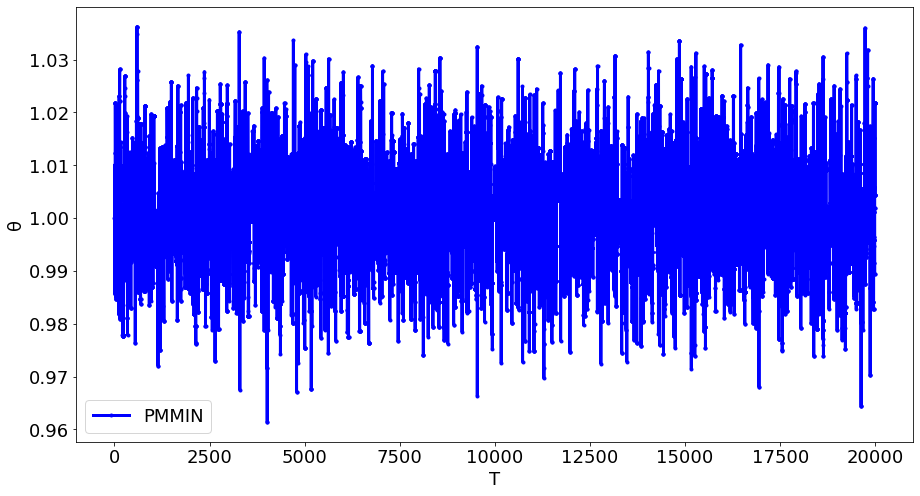

In [527]:
#theta的游程图
xp3=np.arange(T+1)
plt.figure(figsize=(15, 8))
plt.plot(xp3,tn3.transpose(),label='PMMIN',color='blue', linewidth=3,marker='o',markersize=3)
plt.xticks(size=18)
plt.xlabel('T',fontsize=18)
plt.yticks(size=18)
plt.ylabel('θ',fontsize=18)
plt.legend(fontsize=18)

In [264]:
m=100
T=10000
x5=np.zeros((n,5))
for i in range(5):
    x5[:,i]=np.random.normal(1, 1, n)

In [267]:
len(l_mu5[0])

1

In [270]:

l_mu52=[[2],[1.5],[1.7]]
tn_pmmin_52=[]
for i in range(3):
    x55=x5[:,i].reshape((n,1))
    outk,outz,C=clustering(x55,0.1)
    data=x55
    B=generateB(data,outk,outz)
    tn35=PMMIN(x55,outz,outk,C,m,T, l_mu52[i])
    tn_pmmin_52.append(tn35)

0
1
2
3
4
5
6
7
8
9
752.1312260627747
10000
0
1
2
3
4
5
6
7
8
9
755.8890824317932
10000
0
1
2
3
4
5
6
7
8
9
731.1506035327911
10000


IndexError: list index out of range

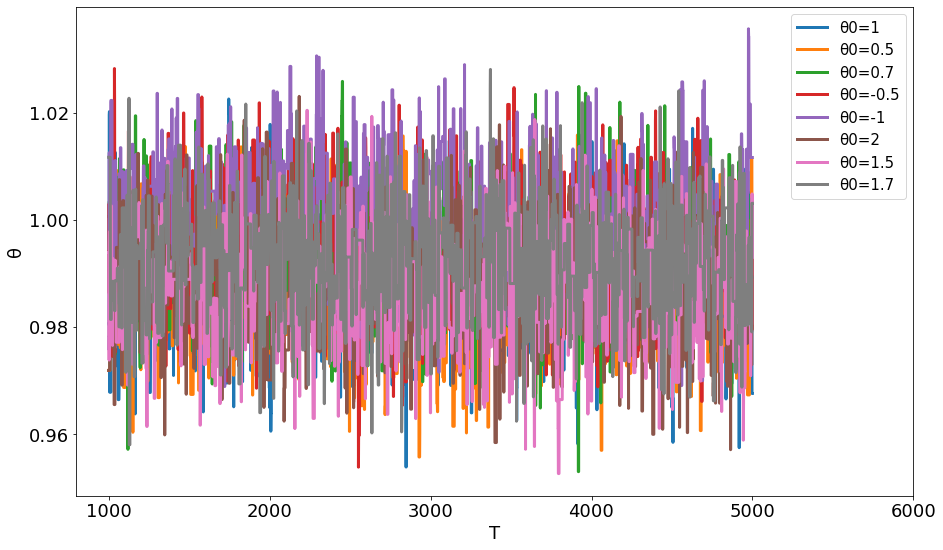

In [316]:
#theta的游程图
xp3=np.arange(5000)
plt.figure(figsize=(15, 9))
plt.axis(xmin = 800, xmax = 6000) 
for i in range(5):
    plt.plot(xp3[1000:],tn_pmmin_5[i].transpose()[1000:5000],label='θ0='+str(l_mu5[i][0]),linewidth=3)
for i in range(3):
    plt.plot(xp3[1000:],tn_pmmin_52[i].transpose()[1000:5000],label='θ0='+str(l_mu52[i][0]),linewidth=3)
    
plt.xticks(size=18)
plt.xlabel('T',fontsize=18)
plt.yticks(size=18)
plt.ylabel('θ',fontsize=18)

plt.legend(fontsize=15)


In [691]:
file = open('E:/研究生/毕业论文/code/tn_pmmin_52.pickle', 'wb') #以.pickle格式保存；二进制写入
pickle.dump(tn_pmmin_52, file) #将a_dict内容写入file
file.close()

In [403]:
print(l_mu5)
tnb=tn_pmmin_5[1]
tnb=tnb[0][5000:]

[[1], [0.5], [0.7], [-0.5], [-1]]


In [380]:
print(l_mu52)

[[2], [1.5], [1.7]]


In [606]:
tnP=tn3[0][:]
tnb

array([1.00493311, 1.00493311, 1.00493311, ..., 1.0044049 , 1.0044049 ,
       1.0044049 ])

In [607]:
%%R -i realmh,tnP

statip::hellinger(realmh,tnP)

[1] 0.02784582


In [608]:
%%R -i tnP
a<-as.mcmc(tnP)
a<-as.numeric(a)
effectiveSize(a)
geweke.diag(a,frac1=0.3, frac2=0.7)


Fraction in 1st window = 0.3
Fraction in 2nd window = 0.7 

   var1 
-0.5037 



In [609]:
robjects.r('a<-as.mcmc(tnP)')
robjects.r('coda::effectiveSize(a<-as.numeric(a))')

2325.449812


In [693]:
file = open('E:/研究生/毕业论文/code/test1/tn3.pickle', 'wb') #以.pickle格式保存；二进制写入
pickle.dump(tn3, file) #将a_dict内容写入file
file.close()

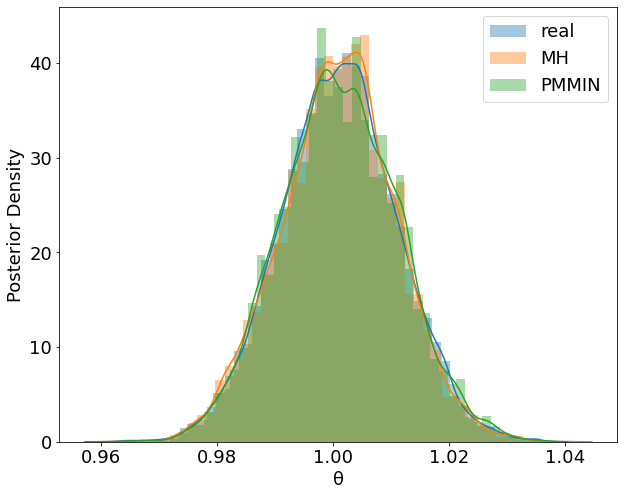

In [514]:
# Histograms for each gender
tn0=tn11[0][:]
tn33=tn3[0][:]
plt.figure(figsize=(10, 8))
real=np.random.normal(zmean,zstd*100,T)
sns.distplot(a=realmh, label="real", kde=True)
sns.distplot(a=tn11.transpose(), label="MH", kde=True)
sns.distplot(a=tn3.transpose(), label="PMMIN", kde=True)
plt.xticks(size=18)
plt.ylabel('Posterior Density',fontsize=18)
plt.yticks(size=18)
plt.xlabel('θ',fontsize=18)
# Add title
#plt.title('Posterior Distribution',size=18)
# Force legend to appear
plt.legend(fontsize=18)
#sns.distplot(a=tn.transpose()[40001:50001,:], kde=False)
#sns.distplot(z, kde=False)
#sns.distplot(a=bayes, kde=False)

In [186]:
%%R -i tn11,tn3
tn3<-as.numeric(tn3)
tn<-as.numeric(tn11)
p1<-ggplot(data=as.data.frame(cbind(tn3,
                                    tn11)))+
  geom_density(aes(tn3,color="ApMHT"))+
  geom_density(aes(tn11,color="MH"))+
  ylab("Density")+
  xlab(expression(theta))+
  scale_colour_manual(name="",
                      values=c("ApMHT"="dodgerblue4",
                               "MH"="red3"),
                      labels=c("ApMHT","MH"))+
  coord_flip()
p2<-ggplot(data=as.data.frame(tn3))+
  geom_line(aes(y=tn3, x=(1:10001),
                color="ApMHT"))+
  xlab("Time")+
  ylab(expression(theta))+
  scale_colour_manual(name="",
                      values=c("ApMHT"="dodgerblue4"))
ggarrange(p1, p2, nrow=2, common.legend = TRUE, legend="bottom")



Error in `check_aesthetics()`:
! Aesthetics must be either length 1 or the same as the data (1): x
Run `]8;;rstudio:run:rlang::last_error()rlang::last_error()]8;;` to see where the error occurred.


R[write to console]: Warning message:

R[write to console]: In cbind(tn3, tn11) :
R[write to console]: 
 
R[write to console]:  number of rows of result is not a multiple of vector length (arg 1)




Error in check_aesthetics(evaled, n) :


RInterpreterError: Failed to parse and evaluate line 'tn3<-as.numeric(tn3)\ntn<-as.numeric(tn11)\np1<-ggplot(data=as.data.frame(cbind(tn3,\n                                    tn11)))+\n  geom_density(aes(tn3,color="ApMHT"))+\n  geom_density(aes(tn11,color="MH"))+\n  ylab("Density")+\n  xlab(expression(theta))+\n  scale_colour_manual(name="",\n                      values=c("ApMHT"="dodgerblue4",\n                               "MH"="red3"),\n                      labels=c("ApMHT","MH"))+\n  coord_flip()\np2<-ggplot(data=as.data.frame(tn3))+\n  geom_line(aes(y=tn3, x=(1:10001),\n                color="ApMHT"))+\n  xlab("Time")+\n  ylab(expression(theta))+\n  scale_colour_manual(name="",\n                      values=c("ApMHT"="dodgerblue4"))\nggarrange(p1, p2, nrow=2, common.legend = TRUE, legend="bottom")\n\n'.
R error message: 'Error in check_aesthetics(evaled, n) :'

In [ ]:
%%R -i tn,tn3
tn3<-as.numeric(tn3)
tn<-as.numeric(tn)
ggplot(data=as.data.frame(cbind(prior_sim,DGP0_GITneiswanger)))+
geom_density(aes(prior_sim[(1:100)], color="Prior"))+
geom_density(aes(DGP0_GITneiswanger,color="Marginal"))+
scale_colour_manual(name="",
values=c("Prior"="red3",
"Marginal"="dodgerblue4"),
labels=c(expression(paste("Marginal of", " ", theta)),"Prior"))+
theme(legend.position="bottom")+
xlab(expression(theta))+
ylab("Density")

In [173]:
file = open('E:/研究生/毕业论文/code/t1_tn_2w.pickle', 'wb') #以.pickle格式保存；二进制写入
pickle.dump(tn, file) #将a_dict内容写入file
file.close()

In [174]:
file = open('E:/研究生/毕业论文/code/t1_tn3_2w.pickle', 'wb') #以.pickle格式保存；二进制写入
pickle.dump(tn3, file) #将a_dict内容写入file
file.close()

m k

In [481]:
file = open('E:/研究生/毕业论文/code/tn_pmmin_m3.pickle', 'rb') #二进制读取
tn_pmmin_m3 = pickle.load(file) #读取结果存入a_dict1
file.close()

In [495]:
[30,100,300]
tnk=tn_pmmin_m3[2][0][:]

In [ ]:
real=np.random.normal(zmean,zstd*100,T)

In [496]:

%%R -i realmh,tnk

statip::hellinger(realmh,tnk)

[1] 0.1113716


# picture

In [697]:
file = open('E:/研究生/毕业论文/code/test1/tnP.pickle', 'wb') #以.pickle格式保存；二进制写入
pickle.dump(tnP, file) #将a_dict内容写入file
file.close()

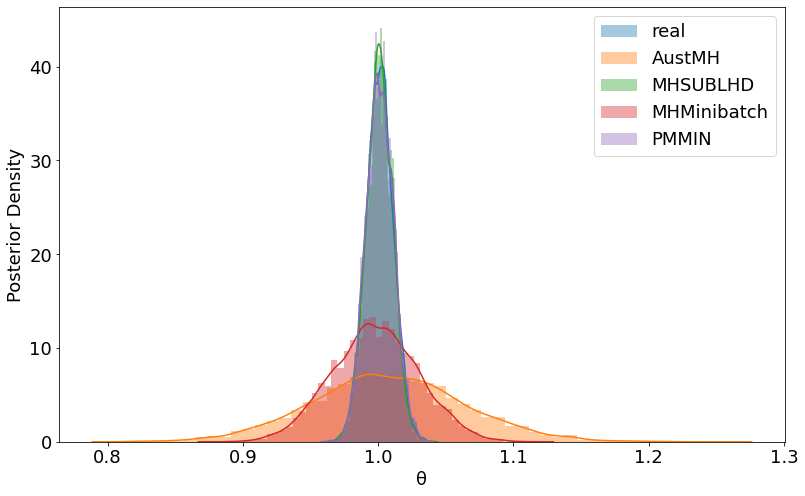

In [646]:

plt.figure(figsize=(13, 8))
real=np.random.normal(zmean,zstd*100,T)
sns.distplot(a=realmh, label="real", kde=True)
#sns.distplot(a=tn11.transpose(), label="MH", kde=True)
sns.distplot(a=tnA.transpose(), label="AustMH", kde=True)
sns.distplot(a=tnC.transpose(), label="MHSUBLHD", kde=True)
sns.distplot(a=tnM.transpose(), label="MHMinibatch", kde=True)
sns.distplot(a=tnP.transpose(), label="PMMIN", kde=True)

plt.xticks(size=18)
plt.ylabel('Posterior Density',fontsize=18)
plt.yticks(size=18)
plt.xlabel('θ',fontsize=18)
# Add title
#plt.title('Posterior Distribution',size=18)
# Force legend to appear
plt.legend(fontsize=18)
#sns.distplot(a=tn.transpose()[40001:50001,:], kde=False)
#sns.distplot(z, kde=False)
#sns.distplot(a=bayes, kde=False)

In [655]:
essmh=3286.491708
essa=1471.447166
essc=2869.446660
essm=2804.706081
essp=2325.449812

IFAustMH=essmh/essa
IFMHSUBLHD=essmh/essc
IFMHMinbatch=essmh/essm
IFPMMIN=essmh/essp
xIF = [1, 2, 3, 4]
yIF=[IFAustMH,IFMHSUBLHD,IFMHMinbatch,IFPMMIN]
print(yIF)

[2.2335098289217137, 1.1453398851470549, 1.1717775813529177, 1.4132713985228764]


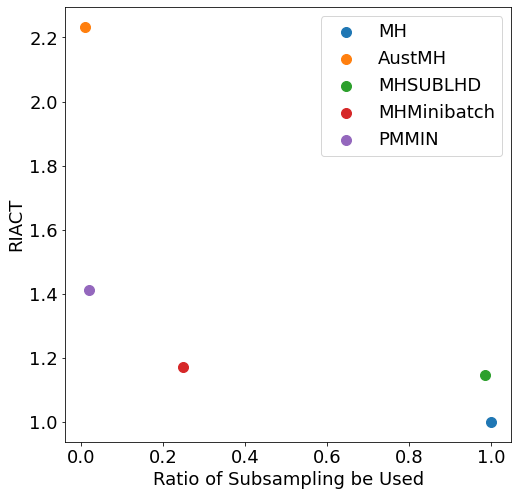

In [689]:
pa=[105.98/n,IFAustMH]
pc=[9850.298/n,IFMHSUBLHD]
pm=[2490.185/n,IFMHMinbatch]
pp=[201/n,IFPMMIN]

plt.figure(figsize=(8, 8))

#sns.distplot(a=tn11.transpose(), label="MH", kde=True)
plt.scatter(1,1, s=100,label="MH")
plt.scatter(pa[0],pa[1], s=100,label="AustMH")
plt.scatter(pc[0],pc[1], s=100,label="MHSUBLHD")
plt.scatter(pm[0],pm[1], s=100,label="MHMinibatch")
plt.scatter(pp[0],pp[1], s=100,label="PMMIN")

plt.xticks(size=18)
plt.ylabel('RIACT',fontsize=18)
plt.yticks(size=18)
plt.xlabel('Ratio of Subsampling be Used',fontsize=18)
# Add title
#plt.title('Posterior Distribution',size=18)
# Force legend to appear
plt.legend(fontsize=18)
#sns.distplot(a=tn.transpose()[40001:50001,:], kde=False)
#sns.distplot(z, kde=False)
#sns.distplot(a=bayes, kde=False)